In [1]:
import requests
import pandas as pd
import concurrent.futures
import time
import csv
from shapely.geometry import shape, mapping

Парсим атрибуты

In [ ]:
# URL для получения атрибутов дороги
BASE_URL_ATTR = "https://xn--d1aluo.xn--p1ai/api-skdf/api/v1/portal/map/mini-passport/{}"
# URL для получения геометрии
BASE_URL_GEOM = "https://xn--d1aluo.xn--p1ai/api-pg/rpc/f_get_object_geom"
# Заголовки для запроса геометрии
HEADERS_GEOM = {
    "Accept": "application/json, text/plain, */*",
    "Content-Type": "application/json",
    "User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/133.0.0.0 Safari/537.36",
    "Cookie": "_ym_uid=1741007348961157402; _ym_d=1741007348; _ym_isad=2; _ym_visorc=w",
    "Content-profile": "gis_api_public"
}

# Имя CSV-файла для сохранения
CSV_FILE = "roads_data.csv"
# Параметры потоковой обработки и задержка между запросами
MAX_WORKERS = 8
DELAY = 0.1  
# Диапазон идентификаторов дорог
ROAD_IDS = range(0, 400000)

# Функция для получения геометрии для заданного object_id,
# интегрируя ваш snippet для извлечения geometry из features[0]
def fetch_geometry(object_id):
    payload = {"object_id": object_id, "object_type": 4}  # object_type: 4 - дороги
    try:
        response = requests.post(BASE_URL_GEOM, headers=HEADERS_GEOM, json=payload, timeout=10)
        response.raise_for_status()
        geo_data = response.json()
        features = geo_data.get("features", [])
        if features:
            geom_dict = features[0].get("geometry")
            if geom_dict:
                geom_obj = shape(geom_dict)
                return geom_obj.wkt  # Возвращаем геометрию в формате WKT
        return None
    except requests.RequestException:
        return None

# Функция для получения атрибутов дороги и её геометрии,
# извлекающая все поля из ответа (используя "code" как ключ)
def fetch_data(road_id):
    url = BASE_URL_ATTR.format(road_id)
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        data = response.json()
        fields = data.get("fields", [])
        geometry_wkt = fetch_geometry(road_id)
        
        # Используем JSON id, если он присутствует, иначе road_id
        result = {"id": data.get("id", road_id), "geometry": geometry_wkt}
        
        # Добавляем все поля, используя "code" как ключ
        for field in fields:
            code = field.get("code")
            value = field.get("value", {}).get("value", "")
            if code:
                result[code] = value
        
        # Если обязательное поле FULL_NAME отсутствует или пустое, пропускаем запись
        if not result.get("FULL_NAME"):
            return None
        
        return result
    except requests.RequestException:
        return None

# Генератор для параллельного получения данных по каждому road_id
def road_data_generator(road_ids):
    with concurrent.futures.ThreadPoolExecutor(max_workers=MAX_WORKERS) as executor:
        futures = {executor.submit(fetch_data, road_id): road_id for road_id in road_ids}
        for future in concurrent.futures.as_completed(futures):
            data = future.result()
            if data:
                yield data
            time.sleep(DELAY)

# Функция для записи данных в CSV.
# Сначала собираем все строки, затем вычисляем объединённый набор ключей,
# сортируем строки по "id" и принудительно помещаем "id" как первую колонку.
def save_to_csv(generator):
    rows = list(generator)
    # Сортировка строк по id
    rows.sort(key=lambda r: r.get("id", 0))
    
    all_keys = set()
    for row in rows:
        all_keys.update(row.keys())
    # Убираем "id", чтобы затем вставить его первым
    if "id" in all_keys:
        all_keys.remove("id")
    # Остальные ключи сортируем по алфавиту
    fieldnames = ["id"] + sorted(all_keys)
    
    with open(CSV_FILE, mode="w", newline="", encoding="utf-8") as file:
        writer = csv.DictWriter(file, fieldnames=fieldnames)
        writer.writeheader()
        for row in rows:
            writer.writerow(row)

if __name__ == "__main__":
    save_to_csv(road_data_generator(ROAD_IDS))
    print(f"Данные успешно сохранены в {CSV_FILE}")

       id  BALANCE_STOIM  CITY  \
23  89047      119.24516   NaN   

                                        CLASS_OF_ROAD CLIMATIC_ZONE  \
23  Обычная автомобильная дорога (нескоростная авт...           III   

      COATING                CONFIRM_USER  CORE_NETWORK  COST  \
23  Грунтовые  Борисова Вероника Петровна           NaN   NaN   

   DATA_CONFIRMATION  ... ROAD_PART  SQUARE SUBGRADE_WIDTH THROUGHPUT  \
23        14.05.2020  ...       NaN     NaN            NaN        100   

   TIME_CONFIRMATION  TOP_SPEED TRAFFIC_INTENSITY  UCHET_NUMBER  \
23          04:14:18         60               NaN      50Н-0720   

                                    VALUE_OF_THE_ROAD  \
23  автомобильная дорога регионального или межмуни...   

                                             geometry  
23  MULTILINESTRING ((8717825.808 7277776.082, 871...  

[1 rows x 39 columns]


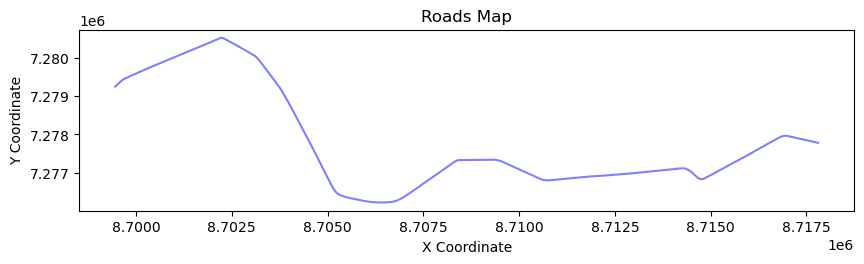

In [18]:
import geopandas as gpd
from shapely import wkt
import matplotlib.pyplot as plt

# Read the CSV file containing road data and geometry in WKT format
df = pd.read_csv("roads_data.csv")

# Convert the 'geometry' column from WKT to Shapely geometry objects
df["geometry"] = df["geometry"].apply(wkt.loads)

# Create a GeoDataFrame, specifying the coordinate reference system (CRS)
# Assuming the WKT geometries are in EPSG:3857 (Web Mercator)
gdf = gpd.GeoDataFrame(df, geometry="geometry", crs="EPSG:3857")
gdf = gdf[23:24]
print(gdf)
# (Optional) Reproject to EPSG:4326 (latitude/longitude) if desired:
#gdf = gdf.to_crs(epsg=4326)

# Plot the map
fig, ax = plt.subplots(figsize=(10, 10))
gdf.plot(ax=ax, color="blue", edgecolor="black", alpha=0.5)
ax.set_title("Roads Map")
ax.set_xlabel("X Coordinate")
ax.set_ylabel("Y Coordinate")
plt.show()

In [11]:
print(gdf)

       id  BALANCE_STOIM  CITY  \
0   89001    68011.92151   NaN   
1   89003    30585.69588   NaN   
2   89005     2047.53097   NaN   
3   89007    21228.55144   NaN   
4   89009      546.35629   NaN   
5   89011       46.93298   NaN   
6   89013      544.19123   NaN   
7   89015       52.18598   NaN   
8   89017    37429.41200   NaN   
9   89019     3867.18856   NaN   
10  89021       11.05408   NaN   
11  89023   592365.75194   NaN   
12  89025     1765.62291   NaN   
13  89027   152778.75112   NaN   
14  89029    93163.79511   NaN   
15  89031       48.44456   NaN   
16  89033    94364.24320   NaN   
17  89035      409.76696   NaN   
18  89037    12095.35176   NaN   
19  89039    31604.07843   NaN   
20  89041     1512.15124   NaN   
21  89043     3341.61656   NaN   
22  89045    18511.13136   NaN   
23  89047      119.24516   NaN   
24  89049       20.64326   NaN   
25  89051   289683.74125   NaN   
26  89053      575.15216   NaN   
27  89055     1059.83292   NaN   
28  89057   11